# Different ways of fitting the splines

In [1]:
# General imports
import matplotlib.pyplot as plt
import numpy as np
import json

### Fit training data to Curvature Constrained Splines
Finally, the splines are fitted to the target defined in the structures.json input file. The splines can be restricted to be fully repulsive ("rep"), fully attractive ("att") or have a turning point/switch ("sw"), which is defined by the "Swtype" key.
* "rep", The resulting spline is purely repulsive, meaning the curvature decreases at further interatomic distances, i.e. c_i > 0 for all i. 
* "att", The resulting spline is purely attractive, meaning the curvature increases at further interatomic distances, i.e. c_i < 0 for all i.
* "sw", The resulting spline is allowed to switch, such that at some point the curvature goes from being positive to being negative. 

In the last case, to search for the optimal switching point there are again three options, which can be set using the "search_mode":
* "full", a brute force implementation, which goes over all points (and all combinations of those specified for other pairs of elements) specified by the cut-off distance Rcut and the resolution "Resolution". This option scales very poorly with the number of elements.
* "range", uses the additional keywords "range_center" and "range_width", searching through all points between \[range_center - range_width/2, range_center + range_width/2\], depending on the resolution.
* "point", uses the additional keyword "search_points", which should be an array of interatomic distances to be probed. The nearest points defined by the resolution will then be probed.

In [2]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

ccs_fetch(mode="CCS",DFT_DB="LJ.db",include_forces=True)

    Fetching data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 543.94it/s]


In [3]:
### Generate input.json file
input={
    "General": {
        "interface": "CCS",
        "merging"  : "True",
    },
    "Twobody": {
                "Xx-Xx": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "full",
                },
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [4]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Cl', 'Na']
    Generating two-body potentials from one-body information.
    Adding pair: Cl-Cl
    Adding pair: Cl-Na
    Adding pair: Na-Na
    Applying monotonous constraints for pair:  Cl-Cl
    Applying monotonous constraints for pair:  Cl-Na
    Applying monotonous constraints for pair:  Na-Na
    There is linear dependence in stochiometry matrix!
    Removing onebody term: Na


    Finding optimum switch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2662/2662 [00:21<00:00, 123.68it/s]


    The best switch is (2, 1, 1) with mse: 6.3155, corresponding to distances of [4.02 1.1  3.97] Å for element pairs ['Cl-Cl', 'Cl-Na', 'Na-Na'].
    Final root mean square error in energy:  0.005766813784176234  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


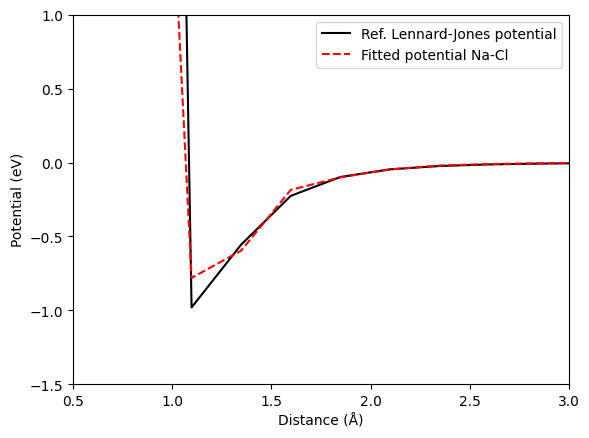

In [5]:
with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)

e = CCS_params["Two_body"]["Cl-Na"]["spl_a"]

r=np.array(CCS_params["Two_body"]["Cl-Na"]["r"])
e_LJ= 4 * ((1 / r) ** 12 - (1 / r) ** 6)

plt.xlim(0.5,3)
plt.ylim(-1.5,1)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
plt.plot(r,e_LJ,color='black',label="Ref. Lennard-Jones potential")
plt.plot(r,e,'--',color='red',label="Fitted potential Na-Cl")
plt.legend()
plt.show()

In [6]:
input={
    "General": {
        "interface": "CCS",
        "merging"  : "True",
    },
    "Twobody": {
                "Cl-Cl": {
                        "Rcut": 6.0,
                        "Resolution": 0.05,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 4.02,
                        "range_width": 0.25 # Å
                },
                "Cl-Na": {
                        "Rcut": 6.0,
                        "Resolution": 0.05,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 1.1,
                        "range_width": 0.25 # Å
                },
                "Na-Na": {
                        "Rcut": 6.0,
                        "Resolution": 0.05,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 3.97,
                        "range_width": 0.25 # Å
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [7]:
#RUN ADDTIONAL FIT

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Cl', 'Na']
    Applying monotonous constraints for pair:  Cl-Cl
    Applying monotonous constraints for pair:  Cl-Na
    Applying monotonous constraints for pair:  Na-Na
    Merging interval for pair Cl-Na. Number of knots reduced from 103 to 96. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: Na
    Range search turned on for element pair Cl-Cl; 5 possible switch indices in range of 3.72-4.22 Å.
    Range search turned on for element pair Cl-Na; 4 possible switch indices in range of 0.95-1.35 Å.
    Range search turned on for element pair Na-Na; 5 possible switch indices in range of 3.82-4.17 Å.


    Finding optimum switch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 27.88it/s]


    The best switch is (6, 5, 2) with mse: 0.033724, corresponding to distances of [3.92 1.2  3.92] Å for element pairs ['Cl-Cl', 'Cl-Na', 'Na-Na'].
    Final root mean square error in energy:  0.0007075620089710095  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


In [8]:
input={
    "General": {
        "interface": "CCS",
        "merging"  : "True",
    },
    "Twobody": {
                "Cl-Cl": {
                        "Rcut": 6.0,
                        "Resolution": 0.01,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [3.92]
                },
                "Cl-Na": {
                        "Rcut": 6.0,
                        "Resolution": 0.01,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 1.2,
                        "range_width": 0.2 # Å
                },
                "Na-Na": {
                        "Rcut": 6.0,
                        "Resolution": 0.01,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [3.92]
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [9]:
#RUN FIT

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Cl', 'Na']
    Applying monotonous constraints for pair:  Cl-Cl
    Applying monotonous constraints for pair:  Cl-Na
    Applying monotonous constraints for pair:  Na-Na
    Merging interval for pair Cl-Cl. Number of knots reduced from 237 to 228. 
    Merging interval for pair Cl-Na. Number of knots reduced from 505 to 422. 
    Merging interval for pair Na-Na. Number of knots reduced from 217 to 215. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: Na
    Switch points located at [3.92] Å to for element pair Cl-Cl based on point search.
    Range search turned on for element pair Cl-Na; 9 possible switch indices in range of 1.00-1.40 Å.
    Switch points located at [3.92] Å to for element pair Na-Na based on point search.


    Finding optimum switch: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.59it/s]


    The best switch is (28, 18, 8) with mse: 3.7543e-05, corresponding to distances of [3.92 1.15 3.92] Å for element pairs ['Cl-Cl', 'Cl-Na', 'Na-Na'].
    Final root mean square error in energy:  0.0002482434843069152  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


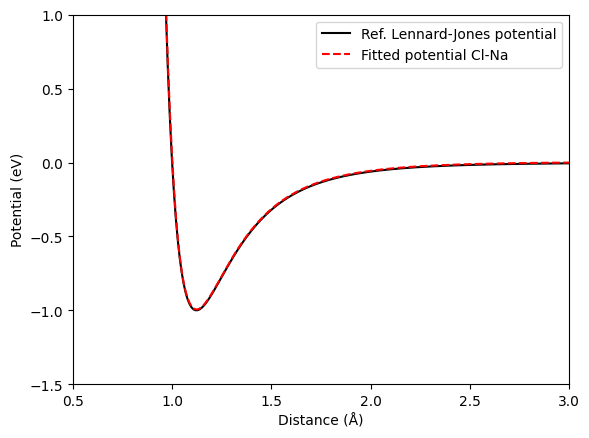

In [10]:
with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)

NaCl = CCS_params["Two_body"]["Cl-Na"]["spl_a"]

r=np.array(CCS_params["Two_body"]["Cl-Na"]["r"])
e_LJ= 4 * ((1 / r) ** 12 - (1 / r) ** 6)

plt.xlim(0.5,3)
plt.ylim(-1.5,1)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
plt.plot(r,e_LJ,color='black',label="Ref. Lennard-Jones potential")
plt.plot(r,NaCl,'--',color='red',label="Fitted potential Cl-Na")
plt.legend()
plt.show()

  0%|                                                                                                                                                                                                                                   | 0/167 [00:00<?, ?it/s]/home/thism292/anaconda3/envs/CCS_Buck/lib/python3.9/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 167/167 [00:00<00:00, 176.64it/s]


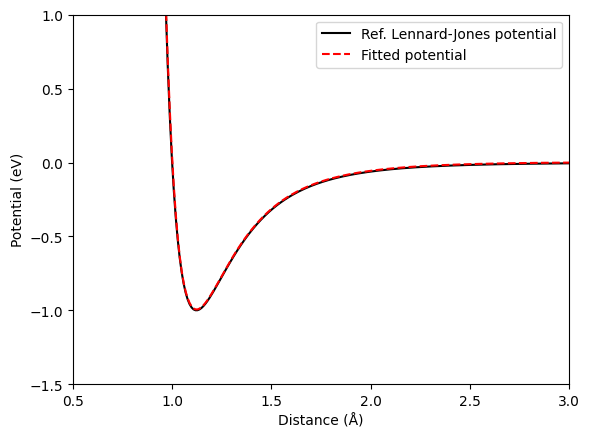

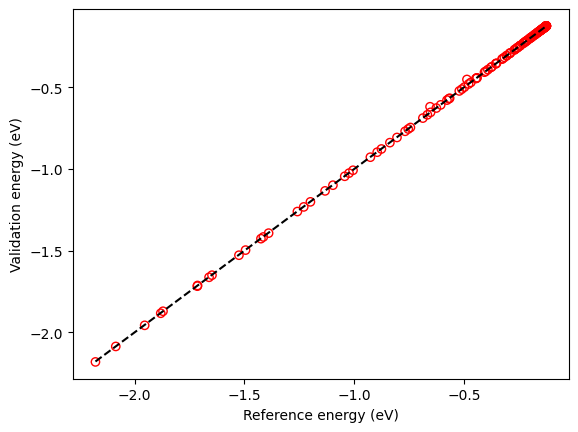

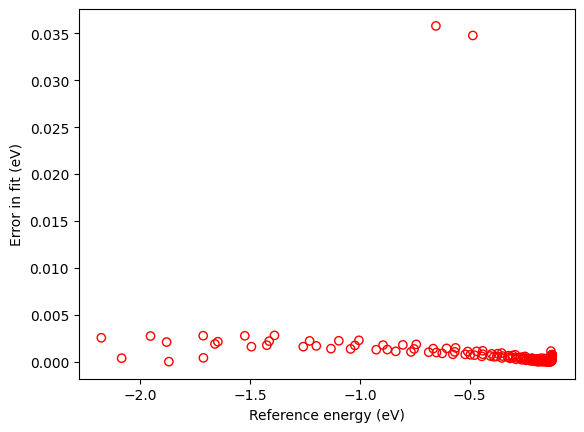

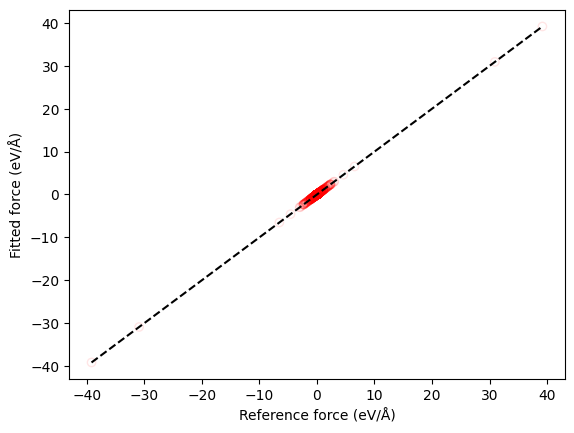

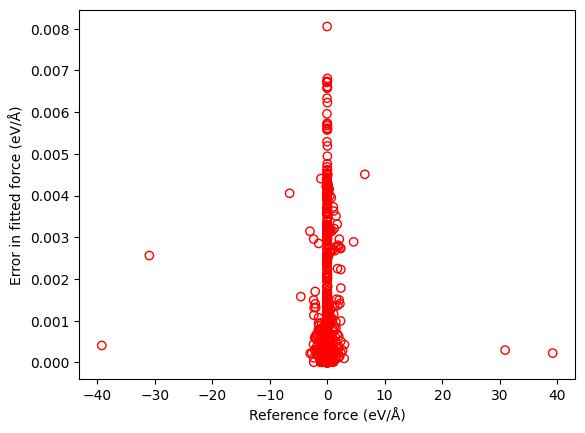

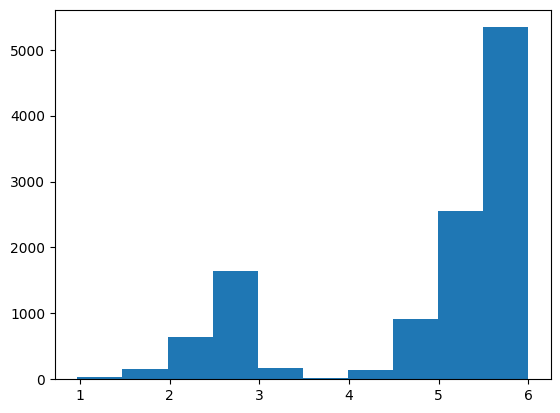

In [11]:
from ccs_fit.scripts.ccs_validate import ccs_validate
ccs_validate(mode="CCS", CCS_params="CCS_params.json", DFT_DB="LJ.db", include_forces=True)

with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)

with open("structures.json", "r") as f:
    training_set = json.load(f)

r=np.array(CCS_params["Two_body"]["Cl-Na"]["r"])
e=CCS_params["Two_body"]["Cl-Na"]["spl_a"]
e_LJ= 4 * ((1 / r) ** 12 - (1 / r) ** 6)
plt.xlim(0.5,3)
plt.ylim(-1.5,1)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
plt.plot(r,e_LJ,color='black',label="Ref. Lennard-Jones potential")
plt.plot(r,e,'--',color='red',label="Fitted potential")
plt.legend()
plt.show()

err=np.loadtxt("CCS_validate.dat")
plt.xlabel('Reference energy (eV)')
plt.ylabel('Validation energy (eV)')
plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
plt.show()
plt.xlabel('Reference energy (eV)')
plt.ylabel('Error in fit (eV)')
plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
plt.show()

err_F=np.loadtxt("CCS_validate_forces.dat")
plt.xlabel('Reference force (eV/Å)')
plt.ylabel('Fitted force (eV/Å)')
plt.plot( [min(err_F[:,0]),max(err_F[:,0])],[min(err_F[:,0]),max(err_F[:,0])],'--',color='black')
plt.scatter(err_F[:,0],err_F[:,1],facecolors='none', edgecolors='red',alpha=0.1 )
plt.show()

plt.xlabel('Reference force (eV/Å)')
plt.ylabel('Error in fitted force (eV/Å)')
plt.scatter(err_F[:,0],err_F[:,2],facecolors='none', edgecolors='red')
plt.show()


d=[]
for t in training_set["energies"]:
    d.extend(training_set["energies"][t]["Na-Cl"])
    
plt.hist(d)
plt.show()

Buckingham fit (not optimised) for element pair Cl-Cl;     V(r) = -0.13*exp(-1.42*r) -(-1.61)/r^6.
Lennard Jones fit (not optimised) for element pair Cl-Cl;  V(r) = 4*0.00*((2.90/r)^12 - (2.90/r)^6)
Morse fit (not optimised) for element pair Cl-Cl;          V(r) = 0.00*(1-np.exp(-3.76*(r-3.84)))^2 + -0.00


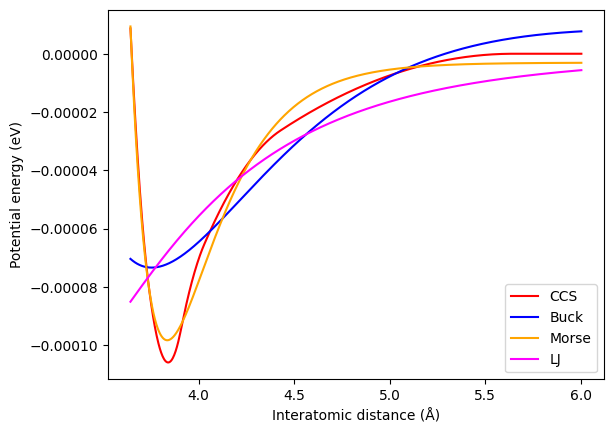

Buckingham fit (not optimised) for element pair Cl-Na;     V(r) = -629.56*exp(-4.19*r) -(-9.59)/r^6.
Lennard Jones fit (not optimised) for element pair Cl-Na;  V(r) = 4*0.99*((1.00/r)^12 - (1.00/r)^6)
Morse fit (not optimised) for element pair Cl-Na;          V(r) = 1.00*(1-np.exp(-5.18*(r-1.14)))^2 + -1.01


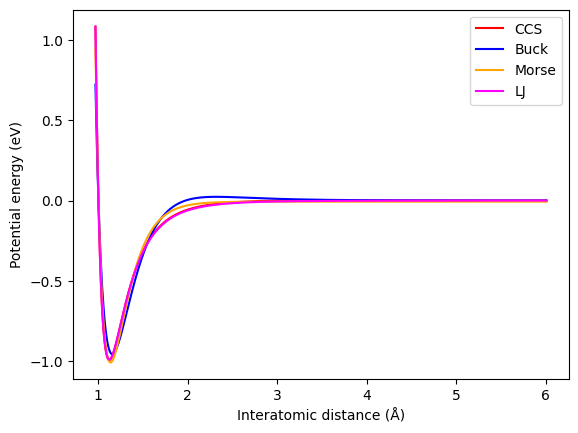

Buckingham fit (not optimised) for element pair Na-Na;     V(r) = -0.34*exp(-1.76*r) -(-0.69)/r^6.
Lennard Jones fit (not optimised) for element pair Na-Na;  V(r) = 4*19.40*((0.43/r)^12 - (0.43/r)^6)
Morse fit (not optimised) for element pair Na-Na;          V(r) = 0.00*(1-np.exp(-2.89*(r-3.82)))^2 + -0.00


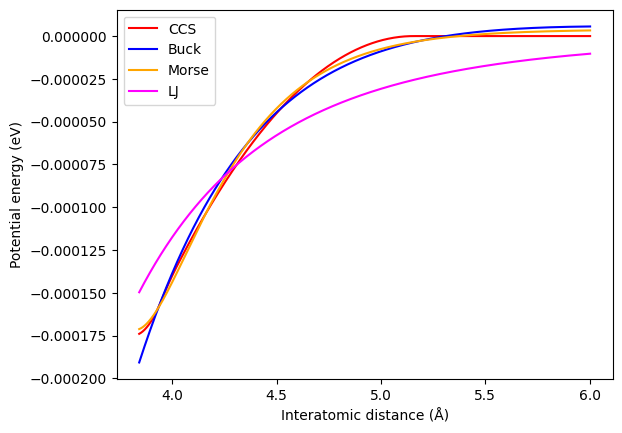

In [12]:
from ccs_fit.scripts.ccs_export_FF import write_FF

write_FF("CCS_params.json")

In [13]:
# Clean up files

import glob
import os

def rm(file):
    try:
        os.remove(file)
    except OSError:
        pass

list=glob.glob("CCS_*")
for file in list:
    rm(file)
rm("structures.json")
rm("ccs.spl")
rm("Buckingham.dat")
rm("Lennard_Jones.dat")
rm("Morse.dat")